# ADF for inference.
---
Start with explaining the core sampling operations.
1. Convolution of gaussians.
2. Greater than operator.

Then introduce the clutter problem as a motivational example.
1. Define the clutter problem as proposed by Minka in his paper.
2. Tease out why exact inference will be a problem even for a modestly sized dataset.
3. Present ADF as a solution.
4. Technical details of AFD.
5. Derive update equations.
6. Solve the clutter problem.

# Useful operations.
---

## 1. Convolution.
\begin{align}
Skill & \sim \mathcal{N}(Skill;\ \mu_s,\,\sigma_s) \\
Performance & \sim \mathcal{N}(Performance;\ Skill,\,\sigma_p) \\
\end{align}

A player's $Skill$ is Normally distributed around a mean skill $\mu_s$ with uncertainity(*standard deviation*) $\sigma_s$. For a completely unknown player, the uncertainity will be large before the evaluation begins and will eventually decrease. A player's performance on game day can vary based on a number of external factors, all of which are assumed to be incorporated in a player's $Performance$ which is also normally distributed around his $Skill$. The uncertainity($\sigma_p$) around the performance can be interpreted as a player's consistency. A consistent player will more often than not, exhibit a performance which is very close to his true skill.

### - Numerical(quantised) computation.
Obtaining a distribution over a player's $Performance: Perf_i$ is straightforward. Seed the player's $Skill: Skill_i$ with a mean and std. Then sample from $Skill_i$. Every $j^{th}$ sampled skill $Skill^j_i$ will serve as the mean for a performance variable $Perf^j_i$. Averaging all performances will give the approximated distribution over the performance.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [2]:
from scipy.stats import norm

In [3]:
s1 = norm(4, np.sqrt(9))

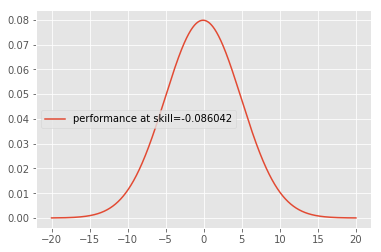

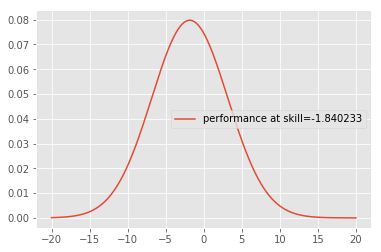

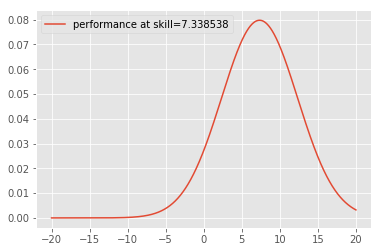

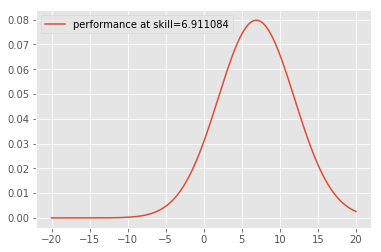

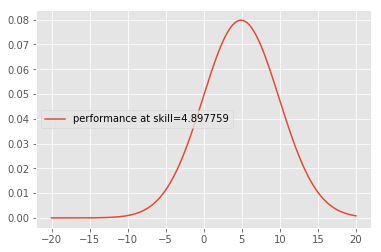

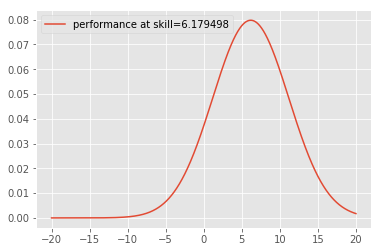

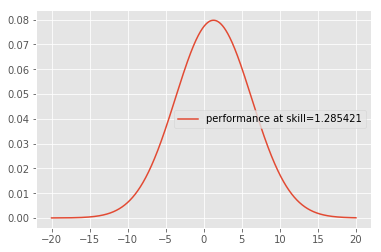

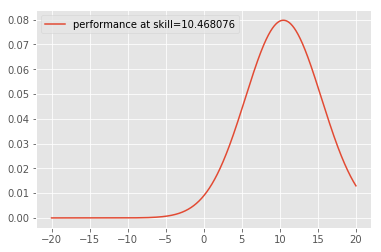

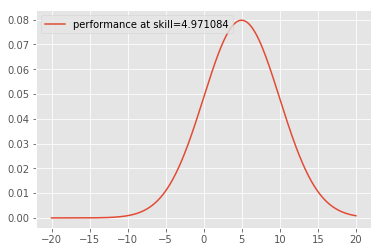

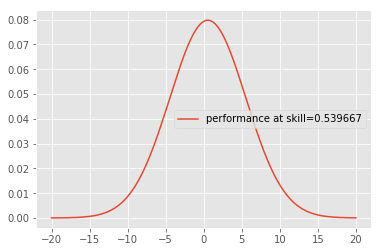

In [7]:
arr = []
for ix in range(5000):    
    vs1 = s1.rvs()
    xs1 = np.linspace(-20, 20, 5000)
    
    p1 = norm(vs1, np.sqrt(25))
    vp1 = p1.rvs()
    xp1 = np.linspace(-20, 20, 5000)
    
    arr.append(p1.pdf(xp1))
    
    if ix%500==0:
        plt.figure()
        plt.plot(xp1, p1.pdf(xp1), label="performance at skill=%f"%vs1)
        plt.legend()

Peak at: 3.94878975795


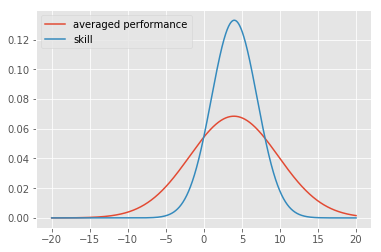

In [8]:
avg = np.mean(np.array(arr), axis=0)
plt.plot(xp1, avg, label="averaged performance")
plt.plot(xs1, s1.pdf(xs1), label="skill")
plt.legend();

print "Peak at:", xp1[np.argmax(avg)]

The approximate mean turns out to be 3.94; the true skill is 4.

### - Analytic computation.
For a more concrete example, we can arrive at the marginal distribution over performance variable $e$: $p(e)$ given:

\begin{align}
p(s) & = \mathcal{N}(s;\ \mu_s,\,\sigma_s^2) \\
p(e|s) & = \mathcal{N}(e;\ s,\,\sigma_e^2) \\
\end{align}

If the joint distribution over $e, s$ is factorised as $p(e|s) p(s)$, then the expression for the marginal becomes:

\begin{align}
& p(e) = \int_s\ p(e|s)\ p(s)\ ds \\
& = \int_s\ \mathcal{N}(e;\ s,\,\sigma_e^2) \ \mathcal{N}(s;\ \mu_s,\,\sigma_s^2) \ ds \\
& = \ ... lotsa\ steps \\
& = \mathcal{N}(e;\ s,\ \sigma_e^2 + \sigma_s^2) \\
\end{align}

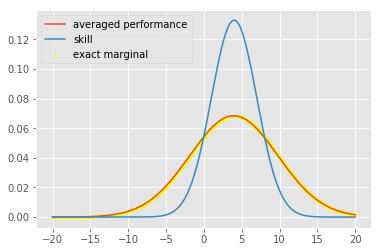

In [47]:
plt.plot(xp1, avg, label="averaged performance")
plt.plot(xs1, s1.pdf(xs1), label="skill")
analytic_posterior = norm(s1.mean(), np.sqrt(s1.var()+p1.var()))

plt.scatter(xs1, analytic_posterior.pdf(xs1), label="exact marginal", s=3, c="yellow")

plt.legend();

## 2. Greater than.
Assuming that the skills of two players (or teams) are known. As demonstrated before, the performances will be normally distributed around said skills. Assuming $perf_{t_1} = 50$ and $perf_{t_2} = 60$ - where $perf_{t_i}$ represents performance of team $i$ - with deviation for both set to $3$, we can plot the distribution over performances as follows.

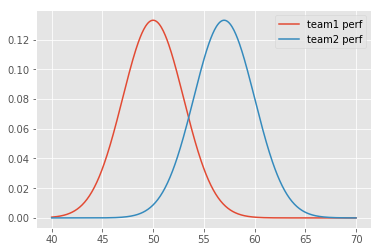

In [17]:
t1 = norm(50, 3)
t2 = norm(57, 3)
xst = np.linspace(40, 70, 500)

plt.plot(xst, t1.pdf(xst), label="team1 perf")
plt.plot(xst, t2.pdf(xst), label="team2 perf")
plt.legend();

Judging by the plots, it appears that team2 is more likely to win (on average) than team1. This "likelihood" of winning can be computed numerically by sampling for each performance variable.

In [20]:
print "Probability of team2 winning against team1:", np.mean([t2.rvs()>t1.rvs() for _ in xrange(10000)])

Probability of team2 winning against team1: 0.9509


Since the performances are normally distributed, the difference between the random variables is also normally distributed. 

In [21]:
team_diff = [t2.rvs() - t1.rvs() for _ in xrange(10000)]

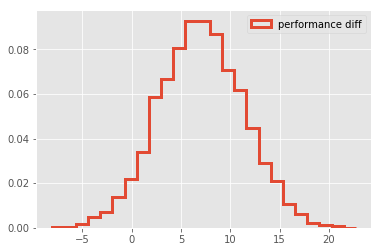

In [34]:
plt.hist(team_diff, bins=25, normed=True, histtype="step", linewidth=3, label="performance diff")
plt.legend();

To be precise, the difference is a normal distribution whose mean is the difference of the mean performances and whose variance is the sum of the team's variances.
$$ p(d = perf_{t_2} > perf_{t_1}) = \mathcal{N}(d;\ \mu_{perf_{t_2}} - \mu_{perf_{t_1}} , \sigma_{perf_{t_2}}^2 + \sigma_{perf_{t_1}}^2) $$

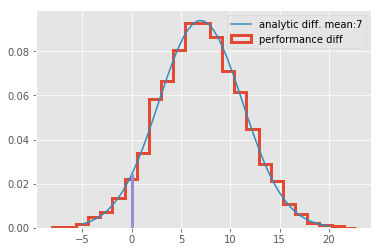

In [38]:
plt.hist(team_diff, bins=25, normed=True, histtype="step", linewidth=3, label="performance diff")
tdiff = norm(t2.mean() - t1.mean(), np.sqrt(t1.var() + t2.var()))
plt.plot(np.linspace(-5, 20), tdiff.pdf(np.linspace(-5, 20)), label="analytic diff. mean:7")

plt.plot([0, 0], [0, tdiff.pdf(0)], linewidth=3)

plt.legend();

And the exact probability of winning is the area under the curve after the purple line. 

In [40]:
print "Exact probability of winning:", 1 - tdiff.cdf(0)

Exact probability of winning: 0.95051992299


# The clutter problem.
---
## 1. Problem statement.
As presented in Minka's paper, the clutter problem is defined as follows. We are given observations from a normal distribution in a noisy environment. The observation density is thus, a mixture of the generator(*true gaussian*) and the noise(*assumed to be another gaussian*).

\begin{align}
p(x|\theta) & = (1-w)\mathcal{N}(x;\ \theta,\, 1) + w\mathcal{N}(x;\ 0,\,10) \\
p(\theta) & = \mathcal{N}(\theta;\ 0, 100) \\
\end{align}

Here, $w$ is the mixing constant know as the ratio of clutter and $\theta$ is the parameter of interest which we have to infer from the observed data. The second equation defines a (weak)prior over $\theta$. Here is the factor graph for the clutter problem.

***Clutter problem factor graph.***
![](media/clutter_problem_factor_graph.png)

## 2. Exact inference.
Consider a dataset $D$ with three points $x1, x2, x3$. If $p(D,\theta)$ is the joint distribution over the $D, \theta$ (as depicted in the factor graph), then the posterior over $\theta$ can be defined as:

\begin{align}
p(\theta | D) & = \frac{p(D, \theta)}{ \int_{\theta} p(D, \theta) \ d\theta } \\
p(D, \theta) & = p(\theta) \prod_{i=1}^3 p(x_i|\theta) \\
\end{align}

The full expression for the joint distribution involves products of $p(x|\theta)$ which has 2 normal distributions. For 3 observed points, that gives $8$ different terms to evaluate. For 100, that would be $2^{100}$ terms to evaluate and integrate over. 

## 3. ADF as a solution.
ADF (**Assumed Density Filtering**) proposes to solve this problem by approimating the posterior and simplifying the process by incorporating a single observed data point at a time.